# DACON 병원 개/폐업 분류 예측 경진대회
[DACON 병원 개/폐업 분류 예측 경진대회](https://dacon.io/competitions/official/9565/overview/description)

## Tensorflow

### 사용 라이브러리

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Data Load

In [2]:
train = pd.read_csv("pre_train.csv")
test = pd.read_csv("pre_test.csv")

train.shape, test.shape

((301, 76), (127, 72))

### Train

In [3]:
label = "open"
feature_names = train.columns.tolist()
feature_names.remove(label)
feature_names.remove("dental_clinic")
feature_names.remove("경상도")
feature_names.remove("광주")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(train[feature_names], train[label], test_size=0.2, stratify=train[label])

print(f"x_train: {x_train.shape}\ny_train: {y_train.shape}\nx_test: {x_test.shape}\ny_test: {y_test.shape}")

x_train: (240, 72)
y_train: (240,)
x_test: (61, 72)
y_test: (61,)


### Model and Train

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(72, input_shape=[x_train.shape[1]]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(144, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="swish"),
    tf.keras.layers.Dense(128, activation="swish"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [6]:
with tf.device("/device:GPU:0"):
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"]
                  )

In [8]:
early_stopping = EarlyStopping(monitor="val_loss", patience=100)

with tf.device("/device:GPU:0"):
    history = model.fit(x_train, y_train, verbose=0, validation_split=0.2, epochs=1000, callbacks=[early_stopping])

In [9]:
df_hist = pd.DataFrame(history.history)
df_hist.tail()

,loss,accuracy,val_loss,val_accuracy
127,0.041207,0.994792,0.593282,0.9375
128,0.028480,0.989583,0.590325,0.9375
129,0.031031,0.984375,0.585470,0.9375
130,0.047607,0.979167,0.588387,0.9375
131,0.029272,0.994792,0.592212,0.9375


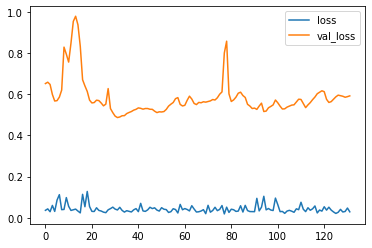

In [10]:
_ = df_hist[["loss", "val_loss"]].plot()

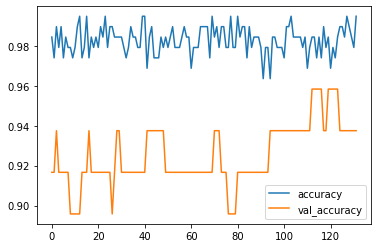

In [11]:
_ = df_hist[["accuracy", "val_accuracy"]].plot()

### Evaluate

In [18]:
y_pred = model.predict(x_test).flatten()

2/2 [==============================] - 0s 3ms/step


In [24]:
pred = (y_pred>0.5).astype(int)

In [25]:
accuracy_score(pred, y_test)

0.9344262295081968

In [12]:
test_loss, test_acc = model.evaluate(x_test,y_test)
print('test loss :',np.round(test_loss,4))
print('test acc :',np.round(test_acc,4))

2/2 [==============================] - 0s 6ms/step - loss: 0.7612 - accuracy: 0.9344
test loss : 0.7612
test acc : 0.9344


### Submission

In [38]:
from glob import glob

sub = pd.read_csv(glob("data/*")[2])

In [39]:
pred = model.predict(test[feature_names])
pred = (pred>0.5).astype(int)
sub["OC"] = pred
sub.to_csv("sub_tf.csv", index=False)

4/4 [==============================] - 0s 19ms/step
